This work is available under the MIT license:

```
Copyright 2024 Seb-sti1

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
```


## Get Image

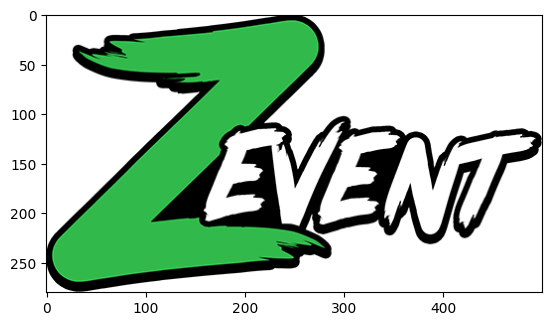

In [8]:



import cv2
import numpy as np
from matplotlib import pyplot as plt

logo = cv2.imread('../data/Zevent_logo.png', cv2.IMREAD_UNCHANGED)
logo = cv2.normalize(logo, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
logo = logo.astype(np.uint8)

plt.imshow(logo)

## Get coordinates of Green/White areas

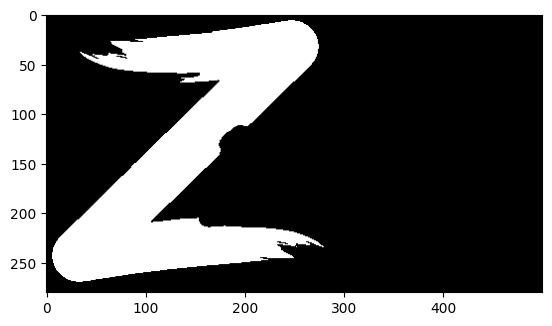

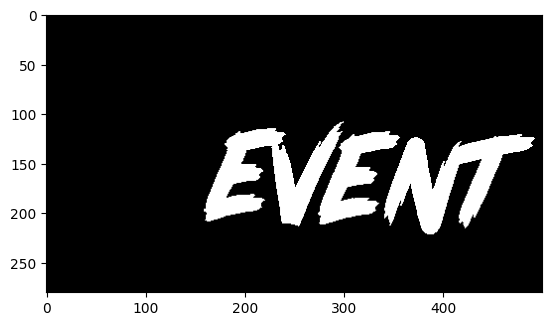

In [2]:
green_mask = cv2.inRange(logo, np.array([20, 100, 50, 100]), np.array([80, 255, 100, 255]))
white_mask = cv2.inRange(logo, np.array([100, 100, 100, 100]), np.array([255, 255, 255, 255]))

plt.imshow(green_mask, cmap='gray')
plt.show()
plt.imshow(white_mask, cmap='gray')

#### Check extractions of coordinates worked

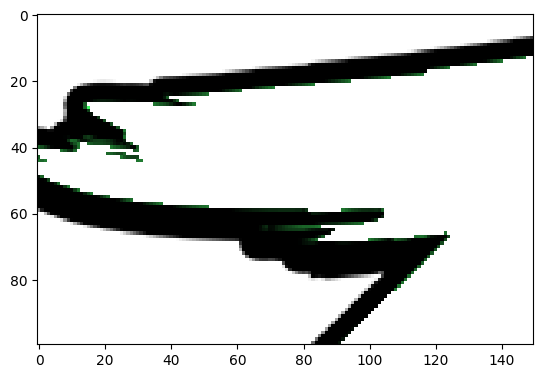

(280, 500, 4)


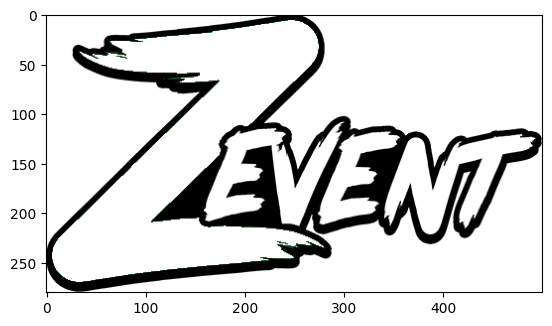

In [3]:
no_green = cv2.bitwise_and(logo, logo, mask=255 - green_mask)

plt.imshow(no_green[0:100, 50:200, 0:4])
plt.show()
plt.imshow(no_green)
print(no_green.shape)
plt.show()

In [4]:
green_coordinates = np.argwhere(green_mask > 0)
white_coordinates = np.argwhere(white_mask > 0)

green_color = [75, 186, 49, 255]
white_color = [100, 100, 100, 255]

all_off_image = cv2.bitwise_and(logo, logo, mask=255 - green_mask)
all_off_image = cv2.bitwise_and(all_off_image, all_off_image, mask=255 - white_mask)

print(f"Number of illuminated pixels {len(green_coordinates) + len(white_coordinates)}")

Number of illuminated pixels 46874


# Load data

In [5]:
import json

with open('../data/dons2024-official.json') as f:
    raw_data = json.loads(f.read())["results"]["A"]["frames"]

data_by_streamer = {}

global_dates = np.array([])

i = 0
for row in raw_data:
    name = row["schema"]["fields"][1]["labels"]["streamer_name"]
    date = row["data"]["values"][0]
    amount = row["data"]["values"][1]
    data_by_streamer[name] = np.array([date, amount]).transpose()
    if global_dates.shape[0] < len(date):
        global_dates = np.array(date)

agg_data = np.zeros((global_dates.shape[0], 2))
agg_data[:, 0] = global_dates[:]

for stream in data_by_streamer:
    dt = np.diff(agg_data[:, 0])
    assert dt.min() == 120000
    assert dt.max() == 120000

for stream in data_by_streamer:
    date = data_by_streamer[stream][:, 0]
    amount = data_by_streamer[stream][:, 1]

    start = np.where(agg_data[:, 0] == date[0])[0][0]
    agg_data[start:amount.shape[0] + start, 1] += amount

end_date = 1725837720
end_date_idx = np.where(agg_data[:-1, 0] == end_date * 1000)[0][0]
agg_data = agg_data[:end_date_idx, :]

## Visualize data

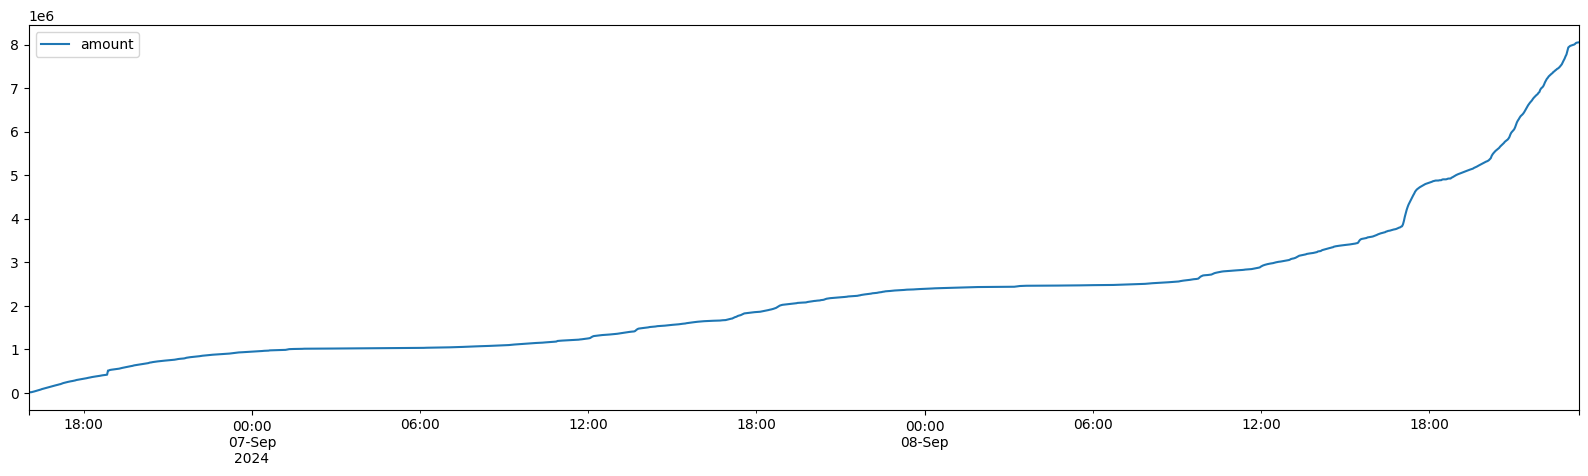

Final amount 8050388.920000001
8041632.0


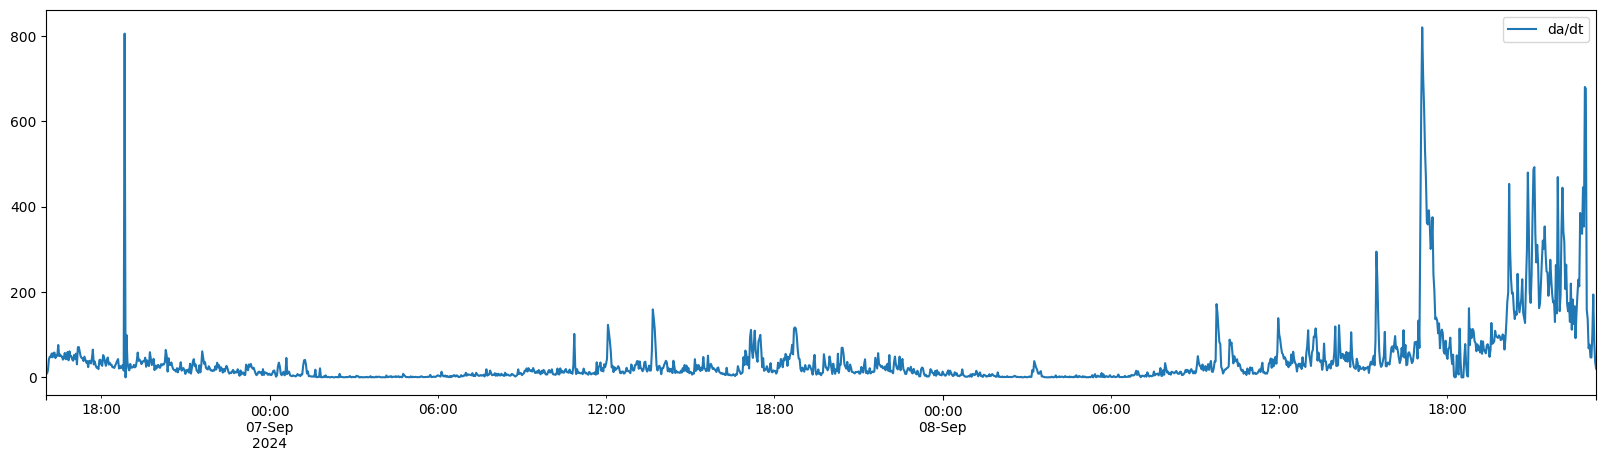

In [7]:
import pandas as pd

dates = pd.to_datetime((agg_data[:, 0] * 1_000_000).astype(int)).values
df = pd.DataFrame({'amount': agg_data[:, 1]}, index=dates)
df.plot(figsize=(20, 5))
plt.show()

da_dt_list = np.divide(np.diff(agg_data[:, 1]), np.diff(agg_data[:, 0]) / 1000)
df = pd.DataFrame({'da/dt': da_dt_list}, index=dates[:-1])
df.plot(figsize=(20, 5))

print(f"Final amount {agg_data[-1, 1]}")
print(sum(np.diff(agg_data[:, 1])))

## Find a good timings for pixels

1725837600 1725638520 199080
8041632.0


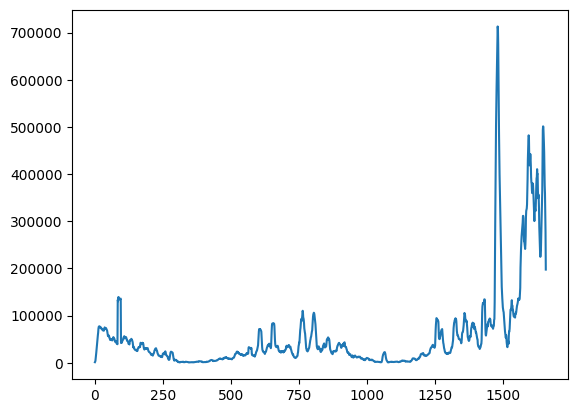

In [8]:
D = [0] * 12

result = []

n = (int(agg_data[-1, 0]) - int(agg_data[0, 0])) // 1000
print(int(agg_data[-1, 0]) // 1000, int(agg_data[0, 0]) // 1000, n)

S = 0

for da_dt_2m in da_dt_list:
    S += da_dt_2m * 120
    D.pop(0)
    D.append(da_dt_2m * 120)
    result.append(sum(D))

plt.plot(result)
print(S)

# Test on coloring random pixels

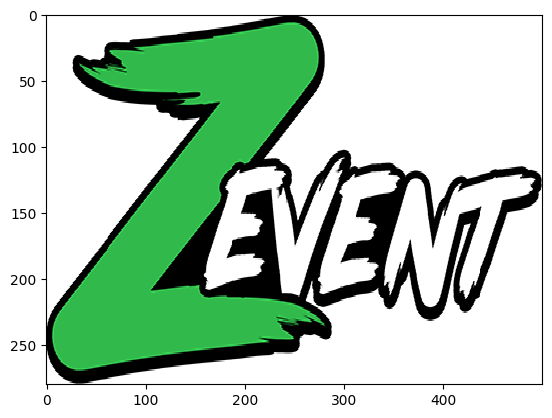

In [9]:
# deactivate matplotlib backend
%matplotlib inline

import random as rand

total_pixels = len(green_coordinates) + len(white_coordinates)
pixels_state_default = np.zeros((total_pixels, 3))
pixels_state_default[:, 2] = False
pixels_state_default[:len(green_coordinates), :2] = green_coordinates
pixels_state_default[len(green_coordinates):, :2] = white_coordinates


def get_random_pixels(pixels_state):
    off_pixels = np.where(pixels_state[:, 2] == False)[0]
    idx = rand.randrange(0, len(off_pixels))
    return off_pixels[idx]


def get_random_image(img, n, pixels_state):
    for i in range(n):
        pixel_idx = get_random_pixels(pixels_state)
        pixels_state[pixel_idx, 2] = True
        x, y = int(pixels_state[pixel_idx, 0]), int(pixels_state[pixel_idx, 1])
        img[x, y, :] = logo[x, y, :]
    return img


base_image = all_off_image.copy()

plt.imshow(get_random_image(base_image.copy(), total_pixels, pixels_state_default.copy()), interpolation='none',
           aspect='auto', vmin=0, vmax=1)
plt.show()

## Create the animation

In [66]:
from tqdm import tqdm

rand.seed(1725837600)
pixel_coords_on = []

pixels_state = pixels_state_default.copy()
pixels_state[:, 2] = 0
# last column is the duration until off (zero is off)
on_duration = 2
nbr_pixel_overflow = 0

data = []

for da_dt_2m in tqdm(da_dt_list):
    nbr_pixels_to_turn_on = int(da_dt_2m * 120)

    # advance "time left until off"
    pixels_state[pixels_state[:, 2] > 0, 2] -= 1

    # get on pixels
    nbr_pixels_turned_on = np.where(pixels_state[:, 2] > 0)[0].shape[0]

    # account for overflow (not enough pixels too many donation)
    nbr_pixels_to_turn_on_and_overflow = nbr_pixels_to_turn_on + nbr_pixel_overflow
    actual_nbr_pixels_to_turn_on = min(nbr_pixels_to_turn_on_and_overflow, total_pixels - nbr_pixels_turned_on)
    nbr_pixel_overflow = nbr_pixels_to_turn_on_and_overflow - actual_nbr_pixels_to_turn_on

    # find the off pixels and select the one to turn on
    off_pixels = np.where(pixels_state[:, 2] == 0)[0]
    coord_new_pixels = [off_pixels[idx] for idx in rand.sample(range(0, len(off_pixels)), actual_nbr_pixels_to_turn_on)]

    # turn them on
    pixels_state[coord_new_pixels, 2] = on_duration

    # save the on pixels
    pixel_coords_on.append(np.where(pixels_state[:, 2] > 0)[0])

    # save data to check
    data.append([nbr_pixels_to_turn_on, nbr_pixel_overflow, nbr_pixels_to_turn_on_and_overflow, nbr_pixels_turned_on,
                 actual_nbr_pixels_to_turn_on])

while nbr_pixel_overflow > 0 or np.where(pixels_state[:, 2] > 0)[0].shape[0] > 0:
    nbr_pixels_to_turn_on = 0

    # advance "time left until off"
    pixels_state[pixels_state[:, 2] > 0, 2] -= 1

    # get on pixels
    nbr_pixels_turned_on = np.where(pixels_state[:, 2] > 0)[0].shape[0]

    # account for overflow (not enough pixels too many donation)
    nbr_pixels_to_turn_on_and_overflow = nbr_pixels_to_turn_on + nbr_pixel_overflow
    actual_nbr_pixels_to_turn_on = min(nbr_pixels_to_turn_on_and_overflow, total_pixels - nbr_pixels_turned_on)
    nbr_pixel_overflow = nbr_pixels_to_turn_on_and_overflow - actual_nbr_pixels_to_turn_on

    # find the off pixels and select the one to turn on
    off_pixels = np.where(pixels_state[:, 2] == 0)[0]
    coord_new_pixels = [off_pixels[idx] for idx in rand.sample(range(0, len(off_pixels)), actual_nbr_pixels_to_turn_on)]

    # turn them on
    pixels_state[coord_new_pixels, 2] = on_duration

    # save the on pixels
    pixel_coords_on.append(np.where(pixels_state[:, 2] > 0)[0])

    # save data to check
    data.append([nbr_pixels_to_turn_on, nbr_pixel_overflow, nbr_pixels_to_turn_on_and_overflow, nbr_pixels_turned_on,
                 actual_nbr_pixels_to_turn_on])

100%|██████████| 1659/1659 [00:03<00:00, 502.43it/s] 


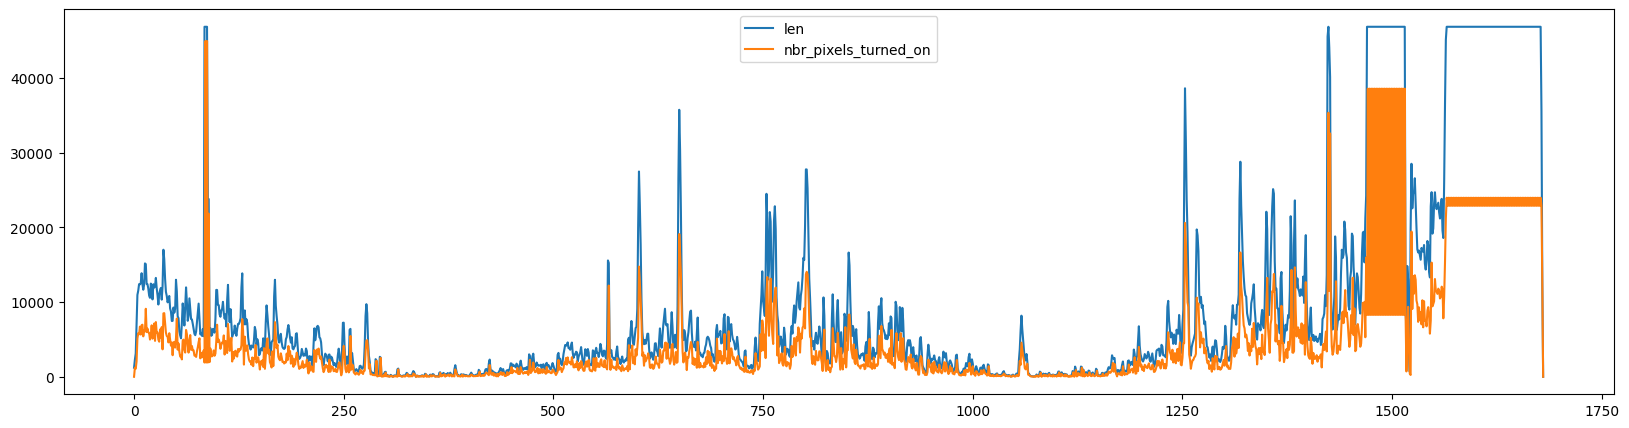

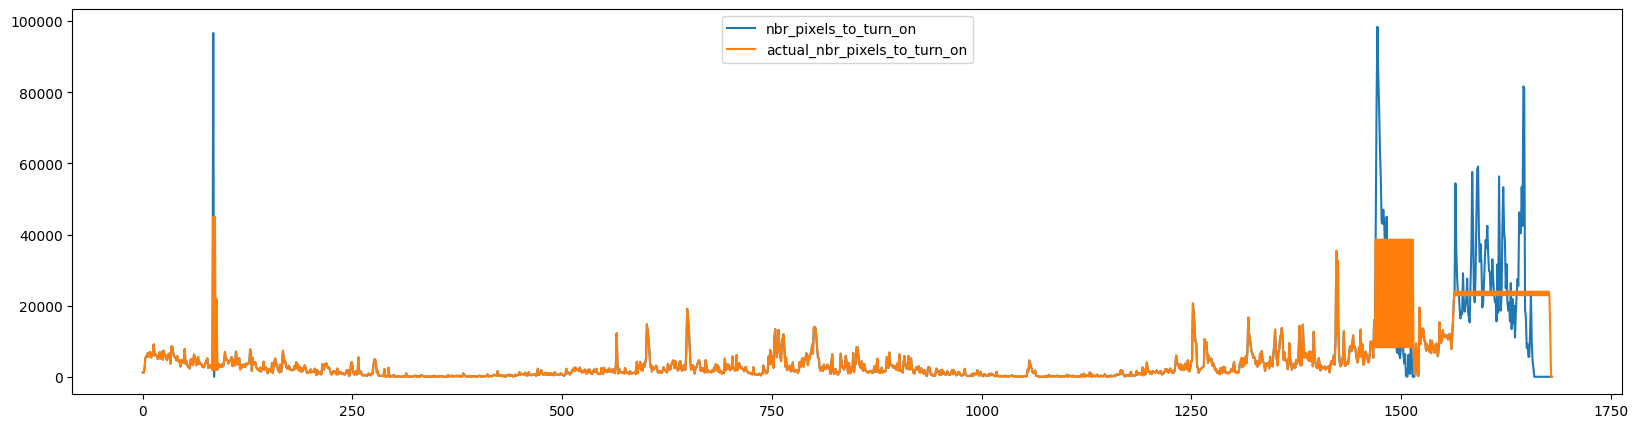

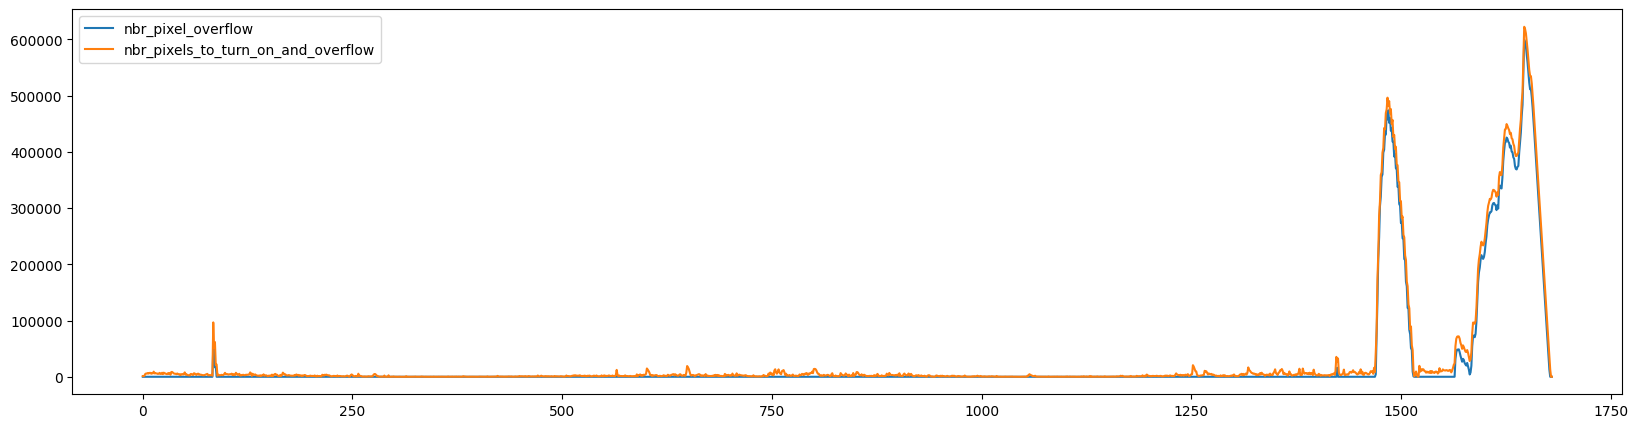

In [68]:
# deactivate matplotlib backend
%matplotlib inline

plt.figure(figsize=(20, 5))
plt.plot([len(p) for p in pixel_coords_on], label="len")
plt.plot([d[3] for d in data], label="nbr_pixels_turned_on")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot([d[0] for d in data], label="nbr_pixels_to_turn_on")
plt.plot([d[4] for d in data], label="actual_nbr_pixels_to_turn_on")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot([d[1] for d in data], label="nbr_pixel_overflow")
plt.plot([d[2] for d in data], label="nbr_pixels_to_turn_on_and_overflow")
plt.legend()
plt.show()


In [70]:

from matplotlib.animation import ArtistAnimation
from datetime import datetime
%matplotlib notebook

fps = 30
nbr_frame = len(pixel_coords_on)
print(f"fps {fps}, nbr_frame {nbr_frame}, dur {nbr_frame / fps}")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
plt.gcf().set_facecolor("#36393e")

plt.imshow(base_image)

ims = [[plt.imshow(base_image, interpolation='none', aspect='auto', vmin=0, vmax=1)]]

date_initial = dates[0].item()//1_000_000_000 + 2*60*60  # correct for UTC+2

for i in tqdm(range(nbr_frame)):
    pixel_on = pixel_coords_on[i]
    current = base_image.copy()
    for pixel_on_idx in pixel_on:
        x, y = pixels_state[pixel_on_idx, :2]
        x, y = int(x), int(y)
        current[x, y, :] = logo[x, y, :]

    d = date_initial + i * 120
    cv2.putText(current, datetime.fromtimestamp(d).strftime('%d %H:%M'), (390, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (210, 210, 210, 255), 2)
    ims.append([plt.imshow(current, interpolation='none', aspect='auto', vmin=0, vmax=1)])

anim = ArtistAnimation(fig, ims, interval=1000 / fps, blit=True, repeat=False)
anim.save('anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

fps 30, nbr_frame 1681, dur 56.03333333333333


<IPython.core.display.Javascript object>

100%|██████████| 1681/1681 [00:19<00:00, 84.89it/s] 
